# Figure understanding & hierarchical document structure analysis

This notebook demonstrates an example of using Azure AI Document Intelligence to ouptut detected figures and hierarchical document structure (in Markdown). It will then crop the figures and send figure content (with its caption) to Azure OpenAI GPT-4o model to understand the semantics. The figure description will be used to update the Markdown output, which can be further used for semantic chunking.

## Install libraries

In [ ]:
%pip install openai azure-ai-documentintelligence azure-identity pillow PyMuPDF

## Init clients for Azure AI Document Intelligence and Azure OpenAI

In [ ]:
import os
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import DocumentContentFormat
from openai import AzureOpenAI

DOCUMENT_INTELLIGENCE_ENDPOINT = "<your-document-intelligence-endpoint>"
DOCUMENT_INTELLIGENCE_API_KEY = "<your-document-intelligence-api-key>"
AZURE_OPENAI_ENDPOINT = "<your-azure-openai-endpoint>"
AZURE_OPENAI_API_KEY = "<your-azure-openai-api-key>"

document_intelligence_client = DocumentIntelligenceClient(
    endpoint=DOCUMENT_INTELLIGENCE_ENDPOINT,
    credential=AzureKeyCredential(DOCUMENT_INTELLIGENCE_API_KEY)
)

aoai_client = AzureOpenAI(
    azure_endpoint=AZURE_OPENAI_ENDPOINT,
    api_key=AZURE_OPENAI_API_KEY,
    api_version="2024-10-01-preview",
)

## Crop figure from the document (pdf or image) based on the bounding box

In [2]:
from PIL import Image
import fitz  # PyMuPDF
import mimetypes

def crop_image_from_image(image_path, page_number, bounding_box):
    """
    Crops an image based on a bounding box.

    :param image_path: Path to the image file.
    :param page_number: The page number of the image to crop (for TIFF format).
    :param bounding_box: A tuple of (left, upper, right, lower) coordinates for the bounding box.
    :return: A cropped image.
    :rtype: PIL.Image.Image
    """
    with Image.open(image_path) as img:
        if img.format == "TIFF":
            # Open the TIFF image
            img.seek(page_number)
            img = img.copy()
            
        # The bounding box is expected to be in the format (left, upper, right, lower).
        cropped_image = img.crop(bounding_box)
        return cropped_image

def crop_image_from_pdf_page(pdf_path, page_number, bounding_box):
    """
    Crops a region from a given page in a PDF and returns it as an image.

    :param pdf_path: Path to the PDF file.
    :param page_number: The page number to crop from (0-indexed).
    :param bounding_box: A tuple of (x0, y0, x1, y1) coordinates for the bounding box.
    :return: A PIL Image of the cropped area.
    """
    doc = fitz.open(pdf_path)
    page = doc.load_page(page_number)
    
    # Cropping the page. The rect requires the coordinates in the format (x0, y0, x1, y1).
    bbx = [x * 72 for x in bounding_box]
    rect = fitz.Rect(bbx)
    pix = page.get_pixmap(matrix=fitz.Matrix(300/72, 300/72), clip=rect)
    
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    
    doc.close()

    return img

def crop_image_from_file(file_path, page_number, bounding_box):
    """
    Crop an image from a file.

    Args:
        file_path (str): The path to the file.
        page_number (int): The page number (for PDF and TIFF files, 0-indexed).
        bounding_box (tuple): The bounding box coordinates in the format (x0, y0, x1, y1).

    Returns:
        A PIL Image of the cropped area.
    """
    mime_type = mimetypes.guess_type(file_path)[0]
    
    if mime_type == "application/pdf":
        return crop_image_from_pdf_page(file_path, page_number, bounding_box)
    else:
        return crop_image_from_image(file_path, page_number, bounding_box)

## Generate figure descriptions with Azure OpenAI GPT-4o model

In [3]:
import base64
import io

# Function to encode an image to a base64 URL 
def image_to_url(image):
    # Read and encode the image file
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")  # You can use JPEG or other formats as needed
    img_bytes = buffered.getvalue()
    img_base64 = base64.b64encode(img_bytes).decode("utf-8")

    # Construct the image URL
    return f"data:image/png;base64,{img_base64}"

In [4]:
def generate_image_description(image):
    """
    Generates a description for an image using the GPT-4o model.

    Parameters:
    - image (str): PIL image.

    Returns:
    - img_description (str): The generated description for the image.
    """

    image_url = image_to_url(image)

    response = aoai_client.chat.completions.create(
        model="gpt-4o",
        messages=[
            { "role": "system", "content": "You are a helpful assistant." },
            { "role": "user", "content": [  
                { 
                    "type": "text", 
                    "text": "Describe this image:" 
                },
                { 
                    "type": "image_url",
                    "image_url": {
                        "url": image_url
                    }
                }
            ] } 
        ],
        max_tokens=2000
    )

    img_description = response.choices[0].message.content
    
    return img_description

## Update Markdown figure content section with the generated figure description

In [ ]:
def update_figure_description(md_content, img_description):
    """
    Updates the figure description in the Markdown content.

    Args:
        md_content (str): The original Markdown content.
        img_description (str): The new description for the image.

    Returns:
        str: The updated Markdown content with the new figure description.
    """

    # The substring you're looking for
    start_substring = "<figure>"
    end_substring = "</figure>"
    new_string = f"<!-- FigureContent=\"{img_description}\" -->"
    
    new_md_content = md_content
    # Find the start and end indices of the part to replace
    start_index = md_content.find(start_substring)
    if start_index != -1:  # if start_substring is found
        end_index = md_content.find(end_substring, start_index)
        if end_index != -1:  # if end_substring is found
            # Replace the old string with the new string
            new_md_content = md_content[:start_index] + new_string + md_content[end_index + len(end_substring):]
    
    return new_md_content

## Analyze a document with Azure AI Document Intelligence Layout model and update Markdown output with generated figure descriptions

In [ ]:
from IPython.display import display

def analyze_layout(input_file_path):
    """
    Analyzes the layout of a document and extracts figures along with their descriptions, then update the Markdown output with the new description.

    Args:
        input_file_path (str): The path to the input document file.

    Returns:
        str: The updated Markdown content with figure descriptions.

    """

    with open(input_file_path, "rb") as f:
        poller = document_intelligence_client.begin_analyze_document(
            "prebuilt-layout",
            body=f,
            content_type="application/octet-stream",
            output_content_format=DocumentContentFormat.MARKDOWN 
        )

    result = poller.result()
    md_content = result.content

    if result.figures:
        print("Figures:")
        for idx, figure in enumerate(result.figures):
            img_description = ""
            for region in figure.bounding_regions:
                # To learn more about bounding regions, see https://aka.ms/bounding-region
                boundingbox = (
                    region.polygon[0],  # x0 (left)
                    region.polygon[1],  # y0 (top
                    region.polygon[4],  # x1 (right)
                    region.polygon[5]   # y1 (bottom)
                )
                # Crop the image from the file
                cropped_image = crop_image_from_file(input_file_path, region.page_number - 1, boundingbox) # page_number is 1-indexed
                print(f"Figure {idx} cropped from page {region.page_number}")
                display(cropped_image)
                # Generate image description
                img_description += generate_image_description(cropped_image)
                print(f"Description of figure {idx}:\n\n{img_description}")

            # Replace figure content in markdown with the new description
            md_content = update_figure_description(md_content, img_description)

    return md_content

Figures:
Figure 0 cropped from page 1


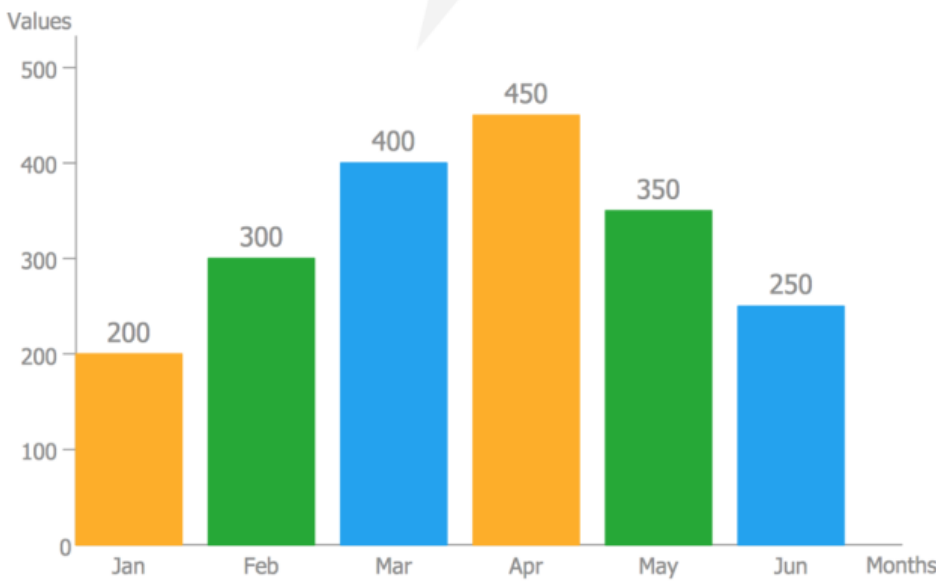

Description of figure 0:

The image is a bar graph displaying values across six months: January through June. Each bar has a distinct color representing the respective month (orange for January, green for February, blue for March, orange for April, green for May, and blue for June). The vertical axis is labeled "Values" and is scaled from 0 to 500 in increments of 100.

Here are the values corresponding to each month:
- January: 200  
- February: 300  
- March: 400  
- April: 450 (highest value)  
- May: 350  
- June: 250  

The trend shows an increase from January to April, followed by a decline in May and June.


In [7]:
file_path = "data/sample-layout-page.pdf"
new_md_content_with_figure_understanding = analyze_layout(file_path)

In [9]:
print(f"Updated markdown content with figure understanding:\n\n{new_md_content_with_figure_understanding}")

Updated markdown content with figure understanding:

<!-- PageHeader="This is the header of the document." -->


# This is title


## 1. Text

Latin refers to an ancient Italic language
originating in the region of Latium in
ancient Rome.


## 2. Page Objects


### 2.1 Table

Here's a sample table below, designed to
be simple for easy understand and quick
reference.


<table>
<caption>Table 1: This is a dummy table</caption>
<tr>
<th>Name</th>
<th>Corp</th>
<th>Remark</th>
</tr>
<tr>
<td>Foo</td>
<td></td>
<td></td>
</tr>
<tr>
<td>Bar</td>
<td>Microsoft</td>
<td>Dummy</td>
</tr>
</table>


### 2.2. Figure


<!-- FigureContent="The image is a bar graph displaying values across six months: January through June. Each bar has a distinct color representing the respective month (orange for January, green for February, blue for March, orange for April, green for May, and blue for June). The vertical axis is labeled "Values" and is scaled from 0 to 500 in increments of 100.

Here are the value